In [1]:
import sys
from pathlib import Path

import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd

sys.path.append('../lib')
from local_paths import analysis_dir, database_dir, mplstyle_path
from summary_utils import verified_update, annotate_unit_df, select_units, summarize_results_per_region
from stats_utils import get_bootstrap_spread
from plot_utils import plot_region_tests, annotate_per_region_axes, axis_off_save_labels

In [2]:
plt.style.use(mplstyle_path)

# Parameters

In [3]:
analysis_name = 'rf_cons'
prefix = 'feat_corr_map-sacc-'
results_dir = analysis_dir + prefix + analysis_name

# analysis-specific conditions
cons_type = 'corr'
conds = ('RF 1', 'RF 2', 'M.pt.')
cond_keys = ('fix1', 'fix2', 'midpoint')
pal = palettable.cartocolors.qualitative.Bold_10.mpl_colors
cond_palette = dict(zip(conds, (pal[i] for i in (1, 0, 4))))

# unit selection
unit_sel_path = database_dir + 'unit_sel/visually_selective.csv.gz'

# statistics
spread_type = 'boots_sem'
stat_tests = (
    # ('RF 1', 'RF 2', 'greater'),
    # ('RF 2', 'RF 1', 'greater'),
    ('RF 1', 'M.pt.', 'greater'),
    ('RF 2', 'M.pt.', 'greater'))

# Load data

In [4]:
unit_df = {'Session': [], 'Unit': []}
results = {k: [] for k in ('rf_cons',)}
coords = {}

results_dir = Path(results_dir).expanduser()
for fp in results_dir.glob('*.h5'):
    with h5.File(fp, 'r') as f:
        try:
            assert f[f'progress_report/{analysis_name}/all_done'][()]
            dset = f['rf_cons/data']
        except (KeyError, AssertionError):
            continue

        unit_names = dset['unit'][()].astype(str)
        verified_update(coords, dict(time=dset['time'][()]))

        conds_ = list(dset['ref_frame'][()].astype(str))
        iconds = [conds_.index(k) for k in cond_keys]
        results['rf_cons'].append(np.nanmean(dset[cons_type][:,iconds], 0))  # shape (ncond, nt, nu)

    unit_df['Session'].append(np.full(unit_names.size, fp.stem))
    unit_df['Unit'].append(unit_names)

print('coordinates:')
for k, v in coords.items():
    print('\t', k, v.shape, v.dtype)
print('results:')
for d in (results, unit_df):
    for k, v in d.items():
        d[k] = v = np.concatenate(v, axis=-1)
        print('', f'{k:<15s}', v.shape, v.dtype, sep='\t')
print(np.unique(unit_df['Session']).size, 'sessions')
unit_df = annotate_unit_df(pd.DataFrame(unit_df))

/tmp/ipykernel_361132/3214957449.py:19: RuntimeWarning: Mean of empty slice
  results['rf_cons'].append(np.nanmean(dset[cons_type][:,iconds], 0))  # shape (ncond, nt, nu)


coordinates:
	 time (31,) float64
results:
	rf_cons        	(3, 31, 26872)	float32
	Session        	(26872,)	<U10
	Unit           	(26872,)	<U4
672 sessions


# Select units

In [5]:
result_vals = results['rf_cons']
del results

In [6]:
unit_df, unit_sel, regions = select_units(
    unit_df,
    selection_path=unit_sel_path,
    select_valid_values=result_vals)

result_vals = result_vals[...,unit_sel]
unit_df.reset_index()[['Session','Unit']].to_csv('unit_sel/fig6f.csv.gz', index=False)

> Selected units: n = 26872 of 26872 (100.0% of data, 99.6% of selection) based on visually_selective.csv.gz
> Selected units: n = 26605 of 26872 (99.0%) with valid values
> Excluded 2 rare subjects per region:
	                Units  Norm. units
	Region Subject                    
	AIT    Ot           7     0.010972
	CIT    Re          28     0.023870
  Selected units: n = 26570 of 26605 (99.9%)


# Summarize results per region

In [7]:
summary = summarize_results_per_region(
    unit_df=unit_df,
    result_vals=result_vals,
    spread_type=spread_type,
    conds=conds,
    stat_tests=stat_tests)

center/spread estimate: boots_sem


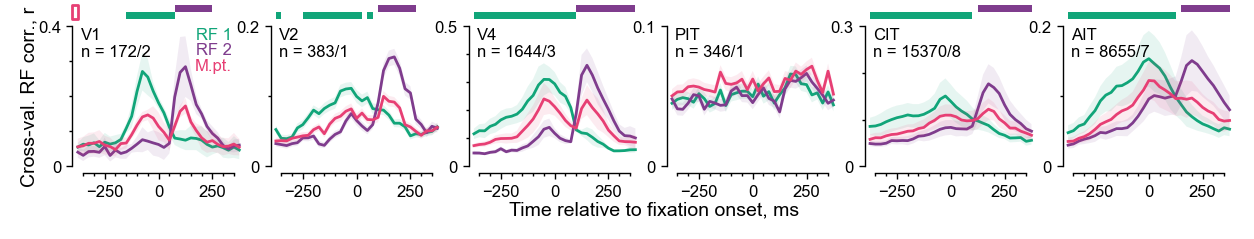

In [8]:
ncol = len(regions)
fig, axs = plt.subplots(1, ncol, figsize=(1.25*ncol,1), sharex=True)
plt.subplots_adjust(wspace=0.15)

ts = coords['time']
ybound = {}
for region, ax in zip(regions, axs):
    m, bs = summary['one-level_center_boots'][region]
    ymax = 0

    for icond, cond in enumerate(conds):
        color = cond_palette[cond]
        ax.plot(ts, m[icond], color=color, zorder=2+icond/10)
        spread = get_bootstrap_spread(m[icond], bs[:,icond], spread_type)
        ax.fill_between(ts, *spread, ec='none', fc=color, alpha=0.1, zorder=1.95+icond/10)
        ymax = max(ymax, spread.max())

    ymax = round(np.ceil(ymax/.1)*.1, 1)
    ybound[region] = (0, max(0.1, ymax))

ymax = plot_region_tests(
    xs=ts, axs=axs, regions=regions,
    summary=summary, palette=cond_palette, ybound=ybound,
    indicate_null=True)

xlim = (-400, 400)
xtks = (-250, 0, 250)
xmtks = np.arange(-350, 351, 50)
for ax in axs:
    ax.set_xlim(xlim)
    ax.set_xticks(xtks)
    ax.set_xticks(xmtks, minor=True)
    ax.spines['bottom'].set_bounds(xmtks.min(), xmtks.max())

for region, ax in zip(regions, axs):
    ybound_ = ybound[region]
    dy = np.array(ybound_).ptp()
    ylim = (ybound_[0]-dy*.05, ybound_[1]+dy*.05)
    ymtks = np.arange(*ybound_, .1)
    ax.set_ylim(ylim)
    ax.set_yticks(ybound_, list(map(str, ybound_)))
    ax.set_yticks(ymtks, minor=True)
    ax.spines['left'].set_bounds(ybound_)

ax = axs[0]
ybound_ = ybound[regions[0]]
ax.set_ylabel('Cross-val. RF corr., r')
tform = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
ax.yaxis.set_label_coords(-.2, np.mean(ybound_), transform=tform)

ax = fig.add_subplot(111)
axis_off_save_labels(ax)
ax.set_xlabel('Time relative to fixation onset, ms', labelpad=10)

annotate_per_region_axes(
    axs,
    regions,
    ns_per_region=summary['two-level_nunit'],
    conds=conds,
    palette=cond_palette,
    h=.95,
    r=.925)

print('center/spread estimate:', spread_type)

plt.savefig('plots/fig6f.png')